In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
import seaborn as sns
df = pd.read_csv('../data/curated/rm_na_df_v2.csv')
df.shape

(4621, 76)

In [2]:
with pd.option_context('display.max_rows', None):
    print(df.isnull().sum())

subject_id                0
hadm_id                   0
gender                    0
anchor_age                0
race                      0
admission_type            0
insurance                 0
marital_status            0
stay_id                   0
deathtime                 0
item_51222                0
item_51265                0
item_51301                0
unique_drugs              0
lods_score                0
oasis_score               0
procedure_221214          0
procedure_221223          0
procedure_223253          0
procedure_224263          0
procedure_224267          0
procedure_224270          0
procedure_224274          0
procedure_224275          0
procedure_224276          0
procedure_224385          0
procedure_225400          0
procedure_225401          0
procedure_225427          0
procedure_225430          0
procedure_225432          0
procedure_225444          0
procedure_225446          0
procedure_225451          0
procedure_225454          0
procedure_225457    

count: Shows the number of non-null entries.

mean: The average of the entries.

std: Standard deviation of the entries.

min: Minimum value.

25%: 25th percentile (first quartile).

50% (median): 50th percentile.

75%: 75th percentile (third quartile).

max: Maximum value.

In [3]:
# Define a list of your continuous variables
continuous_vars = ['anchor_age', 'item_51222', 'item_51265', 'item_51301',
                   'unique_drugs', 'lods_score', 'oasis_score', 'potassium', 'creatinine', 'bun', 
                   'urine_output_total', 'pt', 'systolic_bp', 'mean_arterial_pressure',
                   'heart_rate', 'resp_rate', 'spo2', 'glucose', 'hospital_stay_duration',
                   'icu_stay_duration']

# Calculate comprehensive descriptive statistics
descriptive_stats = df[continuous_vars].describe(percentiles=[.25, .5, .75])
descriptive_stats = descriptive_stats.transpose()
descriptive_stats['var'] = df[continuous_vars].var()

print(descriptive_stats)


                         count        mean         std        min         25%  \
anchor_age              4621.0   66.542307   15.466533  18.000000   56.000000   
item_51222              4621.0   11.998550    2.146820   4.100000   10.600000   
item_51265              4621.0  218.244103   92.577887   6.000000  163.000000   
item_51301              4621.0   11.208894    9.429523   0.300000    7.500000   
unique_drugs            4621.0   41.457477   20.045635   0.000000   26.000000   
lods_score              4621.0    3.900671    2.779307   0.000000    2.000000   
oasis_score             4621.0   31.609392    8.318081  11.000000   26.000000   
potassium               4621.0    4.055529    0.645771   1.400000    3.700000   
creatinine              4621.0    1.151872    1.165178   0.200000    0.700000   
bun                     4621.0   20.962129   14.868532   3.000000   13.000000   
urine_output_total      4621.0  289.629582  269.938461  -1.000000  100.000000   
pt                      4621

In [4]:
# Recode 'deathtime' to a binary column 'mortality_status'
df['mortality_status'] = df['deathtime'].apply(lambda x: '0' if x == '0' else '1')
df.drop(columns=['deathtime'], inplace=True)

print(df.head())


   subject_id   hadm_id gender  anchor_age                    race  \
0    14985844  23126369      M          71                   WHITE   
1    19232236  26305336      M          42                   WHITE   
2    14428378  21698209      M          77                   WHITE   
3    16648184  28237094      M          74                   WHITE   
4    14553598  23439649      F          34  BLACK/AFRICAN AMERICAN   

  admission_type insurance marital_status  stay_id  item_51222  ...  \
0       EW EMER.  Medicare        MARRIED        1        13.4  ...   
1       EW EMER.     Other         SINGLE        1         7.6  ...   
2   DIRECT EMER.  Medicare         SINGLE        1         8.7  ...   
3         URGENT  Medicare         SINGLE        1        11.1  ...   
4       EW EMER.     Other         SINGLE        1        10.3  ...   

   systolic_bp  mean_arterial_pressure  heart_rate  resp_rate  spo2  glucose  \
0        129.0                    86.0        82.0       19.0  99.0    4

In [5]:
# Rename the 'ventilation_duration' column to 'ventilation_used'
df.rename(columns={'ventilation_duration': 'ventilation_used'}, inplace=True)
pd.set_option('display.max_columns', None)
print(df)

      subject_id   hadm_id gender  anchor_age                    race  \
0       14985844  23126369      M          71                   WHITE   
1       19232236  26305336      M          42                   WHITE   
2       14428378  21698209      M          77                   WHITE   
3       16648184  28237094      M          74                   WHITE   
4       14553598  23439649      F          34  BLACK/AFRICAN AMERICAN   
...          ...       ...    ...         ...                     ...   
4616    12025783  26978470      M          78                   WHITE   
4617    14131015  23850711      F          80  WHITE - OTHER EUROPEAN   
4618    16964010  23920941      F          50         ASIAN - CHINESE   
4619    18965721  27282483      F          62                   WHITE   
4620    19247572  25307835      F          88                   WHITE   

         admission_type insurance marital_status  stay_id  item_51222  \
0              EW EMER.  Medicare        MARRIED  

In [6]:
continuous_variables = ['anchor_age', 'item_51222', 'item_51265', 'item_51301',
                   'unique_drugs', 'lods_score', 'oasis_score', 'potassium', 'creatinine', 'bun', 
                   'urine_output_total', 'pt', 'systolic_bp', 'mean_arterial_pressure',
                   'heart_rate', 'resp_rate', 'spo2', 'glucose', 'hospital_stay_duration',
                   'icu_stay_duration']

# List of categorical variables
categorical_variables = [
    'subject_id', 'hadm_id', 'stay_id', 'ventilation_used', 'gender',
    'mortality_status', 'admission_type', 'insurance', 'marital_status', 'race'
] + [col for col in df.columns if col.startswith('procedure_')]

Mann-Whitney U Test:
Used for comparing independent samples to see if they come from the same distribution.


In [7]:
def mann_whitney_test(df, continuous_features, target):
    significant_features = []
    insignificant_features = []
    for feature in continuous_features:
        group1 = df[df[target] == '0'][feature].dropna()
        group2 = df[df[target] == '1'][feature].dropna()
        
        # Perform Mann-Whitney U Test
        stat, p_value = mannwhitneyu(group1, group2)
        
        # Check if the p-value is significant
        if p_value < 0.05:
            print(f'Mann-Whitney U Test for {feature}: p-value={p_value}')
            significant_features.append(feature)
        else:
            print(f'Mann-Whitney U Test for {feature}: p-value={p_value}')
            insignificant_features.append(feature)
    
    print("\nSignificant Features (p-value < 0.05):")
    for feature in significant_features:
        print(feature)

    print("\nInsignificant Features (p-value > 0.05):")
    for feature in insignificant_features:
        print(feature)

    return significant_features

significant_continuous_features_mann_whitney = mann_whitney_test(df, continuous_variables, 'mortality_status')


Mann-Whitney U Test for anchor_age: p-value=1.4223837003856633e-10
Mann-Whitney U Test for item_51222: p-value=5.9325060111283676e-12
Mann-Whitney U Test for item_51265: p-value=2.4532591923754547e-05
Mann-Whitney U Test for item_51301: p-value=3.24131498504008e-32
Mann-Whitney U Test for unique_drugs: p-value=1.1115408873514827e-10
Mann-Whitney U Test for lods_score: p-value=8.764526534383346e-123
Mann-Whitney U Test for oasis_score: p-value=2.1113207160718015e-122
Mann-Whitney U Test for potassium: p-value=0.0012953862269542826
Mann-Whitney U Test for creatinine: p-value=4.276410530938081e-15
Mann-Whitney U Test for bun: p-value=2.027293488779814e-26
Mann-Whitney U Test for urine_output_total: p-value=6.499721055215273e-13
Mann-Whitney U Test for pt: p-value=6.29389474335933e-23
Mann-Whitney U Test for systolic_bp: p-value=0.005978549962031942
Mann-Whitney U Test for mean_arterial_pressure: p-value=0.0016948102931820144
Mann-Whitney U Test for heart_rate: p-value=2.2385123009210558e-

In [8]:
def chi_square_test(df, categorical_features, target):
    significant_features = []
    not_significant_features = []
    
    # Ensure all categorical features are treated as categorical
    for feature in categorical_features:
        df[feature] = df[feature].astype('category')
    
    for feature in categorical_features:
        if len(df[feature].unique()) == 1:
            continue
        # Create contingency table
        table = pd.crosstab(df[feature], df[target])
        chi2, p_value, _, _ = chi2_contingency(table)
        print(f'Chi-Square Test for {feature}: p-value={p_value}')
        
        # Classify features as significant or not significant
        if p_value < 0.05:
            significant_features.append(feature)
        else:
            not_significant_features.append(feature)
    
    return significant_features, not_significant_features

significant_categorical_features_chi_square, not_significant_categorical_features_chi_square = chi_square_test(df, categorical_variables, 'mortality_status')

print("Significant categorical features:")
print(significant_categorical_features_chi_square)

print("\nNot significant categorical features:")
print(not_significant_categorical_features_chi_square)


Chi-Square Test for subject_id: p-value=0.4930835864881396
Chi-Square Test for hadm_id: p-value=0.4930835864881396
Chi-Square Test for ventilation_used: p-value=8.862564598663076e-49
Chi-Square Test for gender: p-value=0.6333880672959782
Chi-Square Test for mortality_status: p-value=0.0
Chi-Square Test for admission_type: p-value=7.133152289979002e-12
Chi-Square Test for insurance: p-value=0.005552645286435079
Chi-Square Test for marital_status: p-value=2.789168513976944e-43
Chi-Square Test for race: p-value=2.802112515035457e-22
Chi-Square Test for procedure_221214: p-value=0.0005970236041497007
Chi-Square Test for procedure_221223: p-value=6.808944154152356e-07
Chi-Square Test for procedure_223253: p-value=9.644740748313146e-10
Chi-Square Test for procedure_224263: p-value=1.1266462911702174e-41
Chi-Square Test for procedure_224267: p-value=0.000110130642064178
Chi-Square Test for procedure_224270: p-value=3.1119466084628715e-16
Chi-Square Test for procedure_224274: p-value=0.0001998

                        anchor_age  item_51222  item_51265  item_51301  \
anchor_age                1.000000   -0.144295   -0.081896   -0.100657   
item_51222               -0.144295    1.000000    0.096837    0.096187   
item_51265               -0.081896    0.096837    1.000000    0.259009   
item_51301               -0.100657    0.096187    0.259009    1.000000   
unique_drugs             -0.076133   -0.238063   -0.099719    0.164623   
lods_score                0.137153   -0.263317   -0.125787    0.132933   
oasis_score               0.291819   -0.195623   -0.087504    0.140592   
potassium                 0.067288   -0.003599    0.065263    0.052931   
creatinine                0.142722   -0.084487   -0.114230    0.029047   
bun                       0.323946   -0.212593   -0.133746    0.031330   
urine_output_total       -0.158090    0.161855    0.055387   -0.009937   
pt                        0.092092   -0.259486   -0.139171    0.062524   
systolic_bp               0.118333    

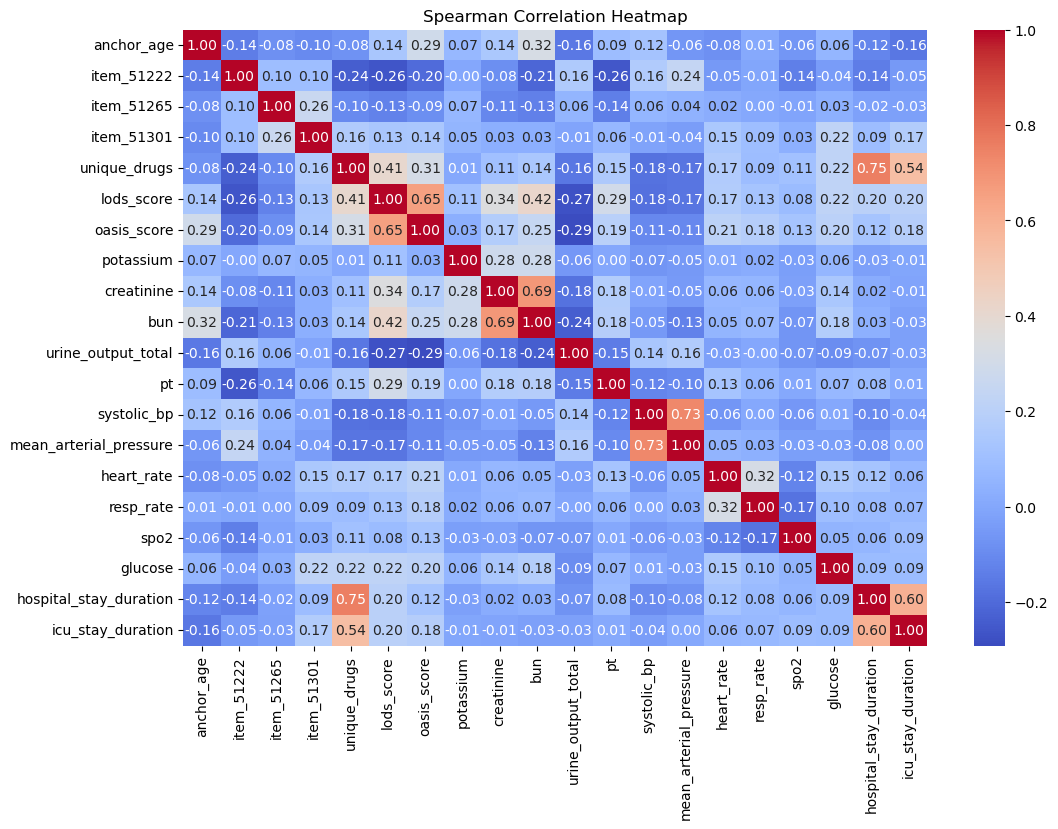

Highly correlated pairs:


In [9]:
def spearman_correlation(df, continuous_features, threshold=0.8):
    # Calculate the Spearman correlation matrix
    corr_matrix = df[continuous_features].corr(method='spearman')
    print(corr_matrix)
    
    # Find pairs of features with correlation higher than the threshold
    correlated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                correlated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))
                print(f'Highly correlated pair: {corr_matrix.columns[i]} and {corr_matrix.columns[j]}')

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Spearman Correlation Heatmap')
    plt.savefig('spearman_correlation_plot.png')
    plt.show()

    return correlated_pairs

correlated_pairs = spearman_correlation(df, continuous_variables, threshold=0.8)

print("Highly correlated pairs:")
for pair in correlated_pairs:
    print(pair)


One hot encoding

In [10]:
categorical_columns = ['gender', 'race', 'admission_type', 'insurance', 'marital_status']  # Add all categorical columns
df = pd.get_dummies(df, columns=categorical_columns)

In [11]:
df.shape

(4621, 122)

In [12]:
# Save the DataFrame to a CSV file
df.to_csv('../data/curated/cleaned_data.csv', index=False)

# Optional: Print confirmation
print("DataFrame has been saved as 'cleaned_data.csv'")

DataFrame has been saved as 'cleaned_data.csv'


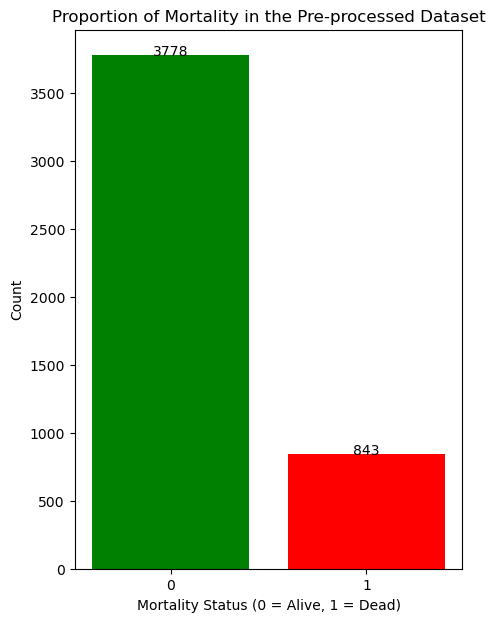

In [13]:
mortality_counts = df['mortality_status'].value_counts()

plt.figure(figsize=(5,7))
plt.bar(mortality_counts.index, mortality_counts.values, color=['green', 'red'])

plt.xlabel('Mortality Status (0 = Alive, 1 = Dead)')
plt.ylabel('Count')
plt.title('Proportion of Mortality in the Pre-processed Dataset')

for index, value in enumerate(mortality_counts.values):
    plt.text(index, value, str(value), ha='center')

plt.savefig('mortality_status_plot.png', dpi=300, bbox_inches='tight')

plt.show()

